/opt/conda/lib/python3.11/site-packages/matplotlib/colors.py:1405: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


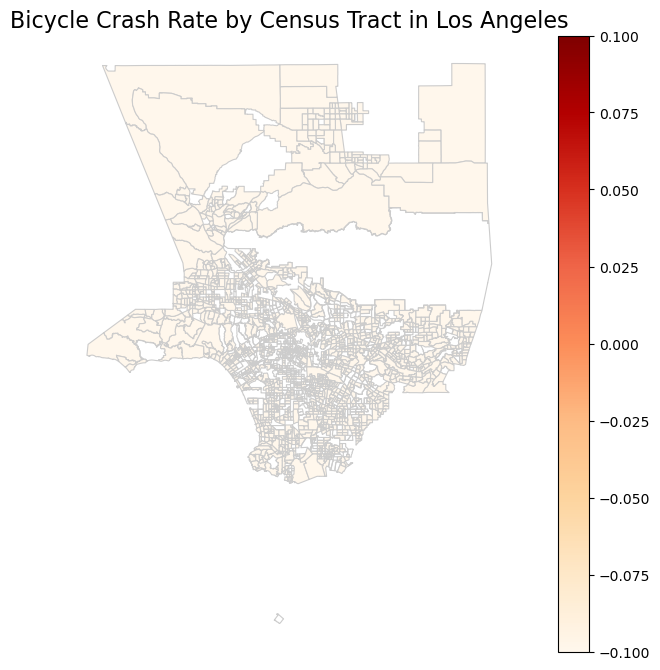

/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: NaN of Infinity value found. Skipped
  ogr_write(


In [5]:
import geopandas as gpd
import pandas as pd

# 1. 加载数据
# 加载 Census Tract 地理边界文件
tracts_path = "2020_Census_Tracts.shp"
census_tracts = gpd.read_file(tracts_path)

# 加载自行车事故数据
bike_crashes_path = "23_Bicycle_Crashes.csv"
bike_crashes = pd.read_csv(bike_crashes_path)

# 2. 转换自行车事故数据为 GeoDataFrame
bike_crashes_gdf = gpd.GeoDataFrame(
    bike_crashes,
    geometry=gpd.points_from_xy(bike_crashes.POINT_X, bike_crashes.POINT_Y),
    crs="EPSG:4326"  # 假设事故数据为 WGS84 坐标系
)

# 3. 确保 Census Tract 边界文件的坐标系一致
census_tracts = census_tracts.to_crs("EPSG:4326")

# 4. 空间关联（Spatial Join）
# 将自行车事故点分配到 Census Tract
bike_crashes_gdf = gpd.sjoin(bike_crashes_gdf, census_tracts, how="inner", predicate="within")

# 5. 按 Census Tract (LABEL) 聚合事故点数量
crash_counts = bike_crashes_gdf.groupby('LABEL').size().reset_index(name='crash_count')

# 6. 合并事故数据与人口数据
# 加载人口数据
population_data_path = "Cleaned_Census_Population.csv"
population_data = pd.read_csv(population_data_path)

# 确保人口数据与地理数据的 LABEL 列一致
population_data['LABEL'] = population_data['Census_Tract_Name'].astype(str)

# 合并数据
merged_data = census_tracts.merge(population_data, on="LABEL", how="left")
merged_data = merged_data.merge(crash_counts, on="LABEL", how="left")

# 填充缺失值
merged_data['crash_count'] = merged_data['crash_count'].fillna(0)
merged_data['Total population'] = merged_data['Total population'].fillna(0)

# 7. 计算事故率
merged_data['crash_rate'] = merged_data['crash_count'] / merged_data['Total population']

# 8. 绘制 Choropleth 地图
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_data.plot(column='crash_rate', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Bicycle Crash Rate by Census Tract in Los Angeles', fontsize=16)
plt.axis('off')
plt.show()

# 9. 保存结果
merged_data.to_file("Census_Tract_Crash_Rates.geojson", driver="GeoJSON")
crash_counts.to_csv("Census_Tract_Crash_Counts.csv", index=False)


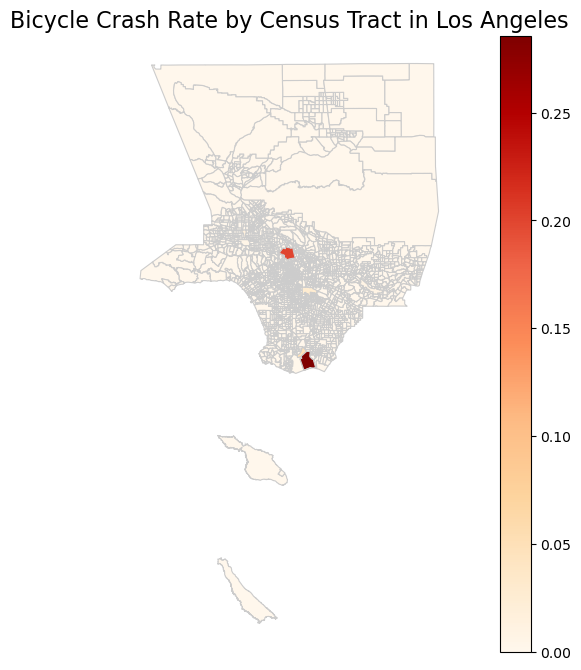

交互式地图已保存为 Bicycle_Crash_Rate_Map.html
回归系数 (Coefficient): -1.193847640903234e-07
截距 (Intercept): 0.0007089544222737049
R² (R-squared): 0.001275528381833091


In [7]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import folium

# 1. 数据加载
# 加载 Census Tract 地理边界文件
tracts_path = "2020_Census_Tracts.shp"
census_tracts = gpd.read_file(tracts_path)

# 加载自行车事故数据
bike_crashes_path = "23_Bicycle_Crashes.csv"
bike_crashes = pd.read_csv(bike_crashes_path)

# 加载人口数据
population_data_path = "Cleaned_Census_Population.csv"
population_data = pd.read_csv(population_data_path)

# 2. 转换自行车事故数据为 GeoDataFrame
bike_crashes_gdf = gpd.GeoDataFrame(
    bike_crashes,
    geometry=gpd.points_from_xy(bike_crashes.POINT_X, bike_crashes.POINT_Y),
    crs="EPSG:4326"  # 假设事故数据为 WGS84 坐标系
)

# 3. 确保 Census Tract 边界文件的坐标系一致
census_tracts = census_tracts.to_crs("EPSG:4326")

# 4. 空间关联（Spatial Join）
# 将自行车事故点分配到 Census Tract
bike_crashes_gdf = gpd.sjoin(bike_crashes_gdf, census_tracts, how="inner", predicate="within")

# 5. 按 Census Tract (LABEL) 聚合事故点数量
crash_counts = bike_crashes_gdf.groupby('LABEL').size().reset_index(name='crash_count')

# 6. 合并事故数据与人口数据
# 确保人口数据与地理数据的 LABEL 列一致
population_data['LABEL'] = population_data['Census_Tract_Name'].astype(str)

# 合并数据
merged_data = census_tracts.merge(population_data, on="LABEL", how="left")
merged_data = merged_data.merge(crash_counts, on="LABEL", how="left")

# 填充缺失值
merged_data['crash_count'] = merged_data['crash_count'].fillna(0)
merged_data['Total population'] = merged_data['Total population'].fillna(0)

# 7. 计算事故率
merged_data['crash_rate'] = merged_data['crash_count'] / merged_data['Total population']

# 数据清洗：替换 inf 和 NaN
merged_data['crash_rate'] = merged_data['crash_rate'].replace([np.inf, -np.inf], np.nan)
merged_data['crash_rate'] = merged_data['crash_rate'].fillna(0)

# 8. 静态 Choropleth 地图
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_data.plot(
    column='crash_rate',
    cmap='OrRd',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True
)
ax.set_title('Bicycle Crash Rate by Census Tract in Los Angeles', fontsize=16)
plt.axis('off')
plt.show()

# 9. 交互式地图生成
# 创建基础地图
m = folium.Map(location=[34.05, -118.25], zoom_start=10)  # 洛杉矶的中心坐标

folium.Choropleth(
    geo_data=merged_data,
    name='Bicycle Crash Rate',
    data=merged_data,
    columns=['LABEL', 'crash_rate'],
    key_on='feature.properties.LABEL',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Bicycle Crash Rate'
).add_to(m)

# 保存交互式地图
m.save("Bicycle_Crash_Rate_Map.html")
print("交互式地图已保存为 Bicycle_Crash_Rate_Map.html")

# 10. 线性回归分析
# 准备回归数据
X = merged_data[['Total population']].values  # 人口密度
y = merged_data['crash_rate'].values          # 自行车事故率

# 初始化线性回归模型
model = LinearRegression()
model.fit(X, y)

# 输出回归结果
print(f"回归系数 (Coefficient): {model.coef_[0]}")
print(f"截距 (Intercept): {model.intercept_}")
print(f"R² (R-squared): {model.score(X, y)}")

# 11. 保存结果
merged_data.to_file("Census_Tract_Crash_Rates.geojson", driver="GeoJSON")
crash_counts.to_csv("Census_Tract_Crash_Counts.csv", index=False)


Linear Regression - Coefficient: -1.193847640903234e-07
Linear Regression - Intercept: 0.0007089544222737049
Linear Regression - R²: 0.001275528381833091
Group Analysis Results:
    density_group  crash_rate
0     Low Density    0.000758
1  Medium Density    0.000173
2    High Density    0.000183
Low-Density Regions with High Crash Rate:
        LABEL  crash_rate                                           geometry
27    1043.22    0.000539  POLYGON ((-118.41799 34.27964, -118.4173 34.27...
380   1434.02    0.000510  POLYGON ((-118.39649 34.15761, -118.39648 34.1...
456   1901.01    0.000625  POLYGON ((-118.3387 34.10154, -118.34015 34.10...
466   1907.01    0.000609  POLYGON ((-118.32666 34.09799, -118.32775 34.0...
582   2060.51    0.001303  POLYGON ((-118.22882 34.04154, -118.22815 34.0...
588   2063.01    0.001005  POLYGON ((-118.24498 34.04458, -118.24584 34.0...
589   2063.02    0.000525  POLYGON ((-118.24388 34.0442, -118.24455 34.04...
599   2073.08    0.000814  POLYGON ((-118.24

/tmp/ipykernel_173/2609127611.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = merged_data.groupby('density_group')['crash_rate'].mean().reset_index()


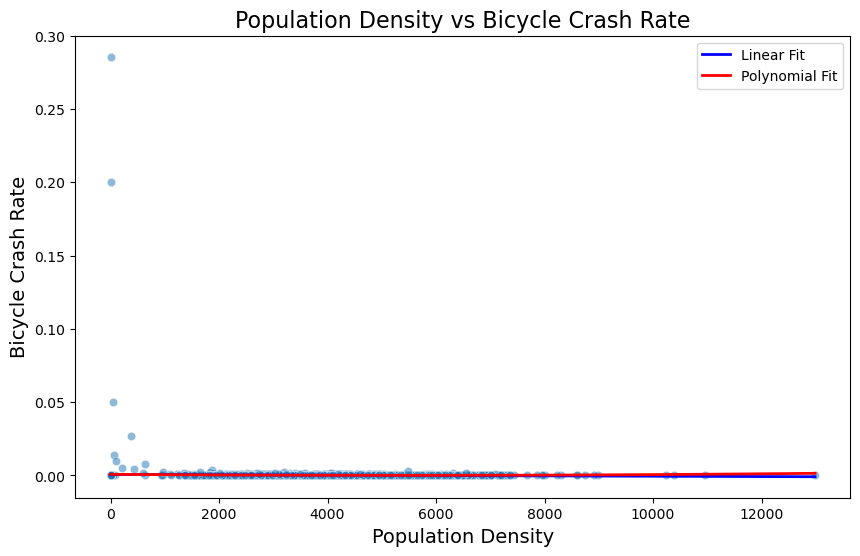

/tmp/ipykernel_173/2609127611.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='density_group', y='crash_rate', data=grouped_data, palette='viridis')


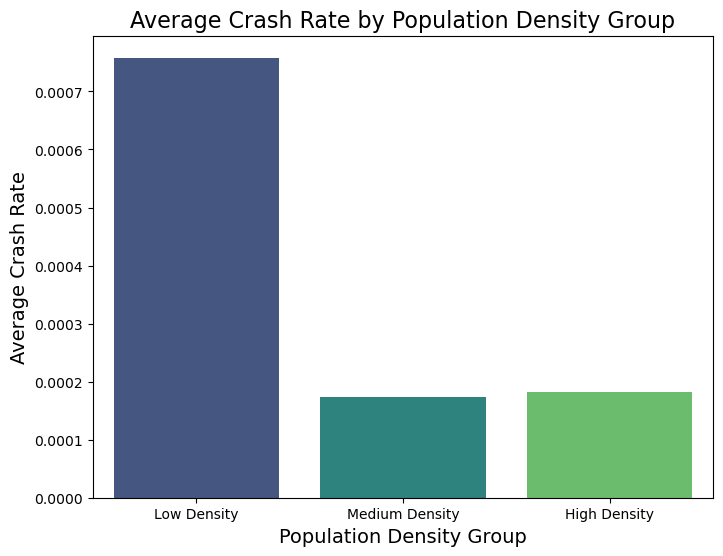

In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import seaborn as sns

# 1. Load data
tracts_path = "2020_Census_Tracts.shp"
census_tracts = gpd.read_file(tracts_path)

bike_crashes_path = "23_Bicycle_Crashes.csv"
bike_crashes = pd.read_csv(bike_crashes_path)

population_data_path = "Cleaned_Census_Population.csv"
population_data = pd.read_csv(population_data_path)

# 2. Data processing
bike_crashes_gdf = gpd.GeoDataFrame(
    bike_crashes,
    geometry=gpd.points_from_xy(bike_crashes.POINT_X, bike_crashes.POINT_Y),
    crs="EPSG:4326"
)
census_tracts = census_tracts.to_crs("EPSG:4326")

# Spatial join
bike_crashes_gdf = gpd.sjoin(bike_crashes_gdf, census_tracts, how="inner", predicate="within")
crash_counts = bike_crashes_gdf.groupby('LABEL').size().reset_index(name='crash_count')

population_data['LABEL'] = population_data['Census_Tract_Name'].astype(str)
merged_data = census_tracts.merge(population_data, on="LABEL", how="left")
merged_data = merged_data.merge(crash_counts, on="LABEL", how="left")
merged_data['crash_count'] = merged_data['crash_count'].fillna(0)
merged_data['Total population'] = merged_data['Total population'].fillna(0)

# Compute crash rate and clean data
merged_data['crash_rate'] = merged_data['crash_count'] / merged_data['Total population']
merged_data['crash_rate'] = merged_data['crash_rate'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 3. Linear regression
X = merged_data[['Total population']].values
y = merged_data['crash_rate'].values

linear_model = LinearRegression()
linear_model.fit(X, y)

# Output linear regression results
print(f"Linear Regression - Coefficient: {linear_model.coef_[0]}")
print(f"Linear Regression - Intercept: {linear_model.intercept_}")
print(f"Linear Regression - R²: {linear_model.score(X, y)}")

# 4. Group analysis
merged_data['density_group'] = pd.qcut(merged_data['Total population'], q=3, labels=['Low Density', 'Medium Density', 'High Density'])

# Compute average crash rate per group
grouped_data = merged_data.groupby('density_group')['crash_rate'].mean().reset_index()
print("Group Analysis Results:")
print(grouped_data)

# Extract low-density regions with high crash rate
low_density_high_crash = merged_data[(merged_data['density_group'] == 'Low Density') & (merged_data['crash_rate'] > 0.0005)]
print("Low-Density Regions with High Crash Rate:")
print(low_density_high_crash[['LABEL', 'crash_rate', 'geometry']])

# 5. Polynomial regression
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

poly_model = LinearRegression()
poly_model.fit(X_poly, y)

# Output polynomial regression results
print(f"Polynomial Regression - Intercept: {poly_model.intercept_}")
print(f"Polynomial Regression - Coefficients: {poly_model.coef_}")
print(f"Polynomial Regression - R²: {poly_model.score(X_poly, y)}")

# 6. Visualization
# Scatter plot with regression lines
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total population', y='crash_rate', data=merged_data, alpha=0.5)
plt.title('Population Density vs Bicycle Crash Rate', fontsize=16)
plt.xlabel('Population Density', fontsize=14)
plt.ylabel('Bicycle Crash Rate', fontsize=14)

# Linear regression line
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
linear_fit = linear_model.predict(x_range)
plt.plot(x_range, linear_fit, color='blue', label='Linear Fit', linewidth=2)

# Polynomial regression line
poly_fit = poly_model.predict(poly.fit_transform(x_range))
plt.plot(x_range, poly_fit, color='red', label='Polynomial Fit', linewidth=2)

plt.legend()
plt.show()

# Group analysis bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='density_group', y='crash_rate', data=grouped_data, palette='viridis')
plt.title('Average Crash Rate by Population Density Group', fontsize=16)
plt.xlabel('Population Density Group', fontsize=14)
plt.ylabel('Average Crash Rate', fontsize=14)
plt.show()


In [4]:
import folium

# 1. 创建基础地图
m = folium.Map(location=[34.05, -118.25], zoom_start=10)  # 洛杉矶的中心坐标

# 2. 添加低密度区域的 Choropleth 图层
folium.Choropleth(
    geo_data=merged_data,
    name='Crash Rate by Census Tract',
    data=merged_data,
    columns=['LABEL', 'crash_rate'],
    key_on='feature.properties.LABEL',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Bicycle Crash Rate'
).add_to(m)

# 3. 筛选低密度区域事故率偏高的区域
low_density_high_crash = merged_data[(merged_data['density_group'] == 'Low Density') & (merged_data['crash_rate'] > 0.0005)]

# 4. 在地图上标记低密度高事故率区域
for _, row in low_density_high_crash.iterrows():
    # 提取区域中心坐标
    centroid = row['geometry'].centroid
    lat, lon = centroid.y, centroid.x

    # 添加标记
    popup_info = f"""
    <b>Tract Label:</b> {row['LABEL']}<br>
    <b>Crash Rate:</b> {row['crash_rate']:.5f}<br>
    <b>Total Population:</b> {row['Total population']}<br>
    """
    folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(popup_info, max_width=300),
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# 5. 保存交互式地图
m.save("Low_Density_High_Crash_Map.html")
print("Interactive map with highlighted low-density regions saved as Low_Density_High_Crash_Map.html")


Interactive map with highlighted low-density regions saved as Low_Density_High_Crash_Map.html


/tmp/ipykernel_173/896929893.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_data['Area_km2'] = merged_data['geometry'].area / 10**6  # Convert area to square kilometers


Interactive map saved as Adjusted_Crash_Rate_Map.html


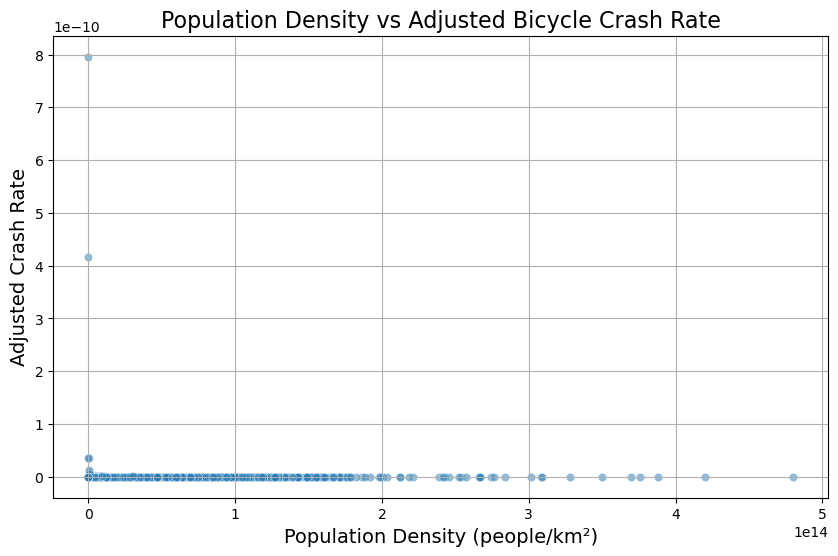

In [5]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import seaborn as sns

# 1. Load data
tracts_path = "2020_Census_Tracts.shp"
census_tracts = gpd.read_file(tracts_path)

bike_crashes_path = "23_Bicycle_Crashes.csv"
bike_crashes = pd.read_csv(bike_crashes_path)

population_data_path = "Cleaned_Census_Population.csv"
population_data = pd.read_csv(population_data_path)

# 2. Data processing
bike_crashes_gdf = gpd.GeoDataFrame(
    bike_crashes,
    geometry=gpd.points_from_xy(bike_crashes.POINT_X, bike_crashes.POINT_Y),
    crs="EPSG:4326"
)
census_tracts = census_tracts.to_crs("EPSG:4326")

# Spatial join
bike_crashes_gdf = gpd.sjoin(bike_crashes_gdf, census_tracts, how="inner", predicate="within")
crash_counts = bike_crashes_gdf.groupby('LABEL').size().reset_index(name='crash_count')

population_data['LABEL'] = population_data['Census_Tract_Name'].astype(str)
merged_data = census_tracts.merge(population_data, on="LABEL", how="left")
merged_data = merged_data.merge(crash_counts, on="LABEL", how="left")
merged_data['crash_count'] = merged_data['crash_count'].fillna(0)
merged_data['Total population'] = merged_data['Total population'].fillna(0)

# Compute population density
merged_data['Area_km2'] = merged_data['geometry'].area / 10**6  # Convert area to square kilometers
merged_data['Population Density'] = merged_data['Total population'] / merged_data['Area_km2']

# Compute adjusted crash rate
merged_data['adjusted_crash_rate'] = merged_data['crash_count'] / merged_data['Population Density']

# Clean data: handle NaN and inf
merged_data['adjusted_crash_rate'] = merged_data['adjusted_crash_rate'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 3. Interactive map highlighting adjusted crash rate
m = folium.Map(location=[34.05, -118.25], zoom_start=10)

folium.Choropleth(
    geo_data=merged_data,
    name='Adjusted Crash Rate',
    data=merged_data,
    columns=['LABEL', 'adjusted_crash_rate'],
    key_on='feature.properties.LABEL',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Adjusted Bicycle Crash Rate (by Density)'
).add_to(m)

# Highlight low-density high-crash regions
low_density_high_crash = merged_data[(merged_data['Population Density'] < 1000) & (merged_data['adjusted_crash_rate'] > 0.001)]

for _, row in low_density_high_crash.iterrows():
    centroid = row['geometry'].centroid
    lat, lon = centroid.y, centroid.x

    popup_info = f"""
    <b>Tract Label:</b> {row['LABEL']}<br>
    <b>Adjusted Crash Rate:</b> {row['adjusted_crash_rate']:.5f}<br>
    <b>Population Density:</b> {row['Population Density']:.2f}<br>
    <b>Area (km²):</b> {row['Area_km2']:.2f}<br>
    """
    folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(popup_info, max_width=300),
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

m.save("Adjusted_Crash_Rate_Map.html")
print("Interactive map saved as Adjusted_Crash_Rate_Map.html")

# 4. Visualize adjusted crash rate
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Population Density', y='adjusted_crash_rate', data=merged_data, alpha=0.5)
plt.title('Population Density vs Adjusted Bicycle Crash Rate', fontsize=16)
plt.xlabel('Population Density (people/km²)', fontsize=14)
plt.ylabel('Adjusted Crash Rate', fontsize=14)
plt.grid(True)
plt.show()


Linear Regression - Coefficient: -9.675002559722952e-27
Linear Regression - Intercept: 9.257383314666439e-13
Linear Regression - R²: 0.0006215584610173019
Polynomial Regression - Intercept: 1.1760989685182856e-12
Polynomial Regression - Coefficients: [ 0.00000000e+00 -2.15698759e-26  5.73971851e-41]
Polynomial Regression - R²: 0.001038314491950798


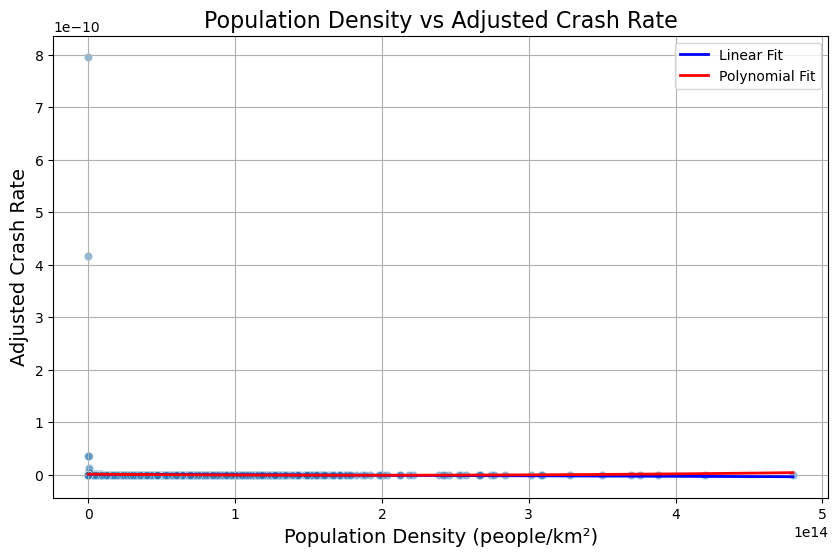

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 数据清理和计算已经在前面完成 (merged_data)

# 准备回归数据
X_density = merged_data[['Population Density']].values  # 自变量：人口密度
y_rate = merged_data['adjusted_crash_rate'].values      # 因变量：调整后的事故率

# 1. 线性回归模型
linear_model_density = LinearRegression()
linear_model_density.fit(X_density, y_rate)

# 输出线性回归结果
print(f"Linear Regression - Coefficient: {linear_model_density.coef_[0]}")
print(f"Linear Regression - Intercept: {linear_model_density.intercept_}")
print(f"Linear Regression - R²: {linear_model_density.score(X_density, y_rate)}")

# 2. 二次多项式回归模型
poly_density = PolynomialFeatures(degree=2)
X_density_poly = poly_density.fit_transform(X_density)

poly_model_density = LinearRegression()
poly_model_density.fit(X_density_poly, y_rate)

# 输出二次回归结果
print(f"Polynomial Regression - Intercept: {poly_model_density.intercept_}")
print(f"Polynomial Regression - Coefficients: {poly_model_density.coef_}")
print(f"Polynomial Regression - R²: {poly_model_density.score(X_density_poly, y_rate)}")

# 3. 可视化分析
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Population Density', y='adjusted_crash_rate', data=merged_data, alpha=0.5)
plt.title('Population Density vs Adjusted Crash Rate', fontsize=16)
plt.xlabel('Population Density (people/km²)', fontsize=14)
plt.ylabel('Adjusted Crash Rate', fontsize=14)

# 绘制线性拟合曲线
x_range_density = np.linspace(X_density.min(), X_density.max(), 100).reshape(-1, 1)
linear_fit_density = linear_model_density.predict(x_range_density)
plt.plot(x_range_density, linear_fit_density, color='blue', label='Linear Fit', linewidth=2)

# 绘制二次拟合曲线
poly_fit_density = poly_model_density.predict(poly_density.fit_transform(x_range_density))
plt.plot(x_range_density, poly_fit_density, color='red', label='Polynomial Fit', linewidth=2)

plt.legend()
plt.grid(True)
plt.show()


In [7]:
import folium

# 筛选异常点：低人口密度且事故率显著高的区域
threshold_crash_rate = 0.001  # 设定异常事故率阈值
threshold_density = 1000     # 设定低密度阈值（人/km²）
outliers = merged_data[(merged_data['Population Density'] < threshold_density) & 
                       (merged_data['adjusted_crash_rate'] > threshold_crash_rate)]

print("Low-density regions with high crash rates (outliers):")
print(outliers[['LABEL', 'Population Density', 'adjusted_crash_rate', 'Area_km2']])

# 创建交互式地图
m = folium.Map(location=[34.05, -118.25], zoom_start=10)  # 洛杉矶中心坐标

# 添加基础 Choropleth 图层
folium.Choropleth(
    geo_data=merged_data,
    name='Adjusted Crash Rate',
    data=merged_data,
    columns=['LABEL', 'adjusted_crash_rate'],
    key_on='feature.properties.LABEL',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Adjusted Crash Rate'
).add_to(m)

# 在地图上标注异常点
for _, row in outliers.iterrows():
    # 计算区域的质心坐标
    centroid = row['geometry'].centroid
    lat, lon = centroid.y, centroid.x

    # 弹出框显示信息
    popup_info = f"""
    <b>Census Tract:</b> {row['LABEL']}<br>
    <b>Population Density:</b> {row['Population Density']:.2f} people/km²<br>
    <b>Adjusted Crash Rate:</b> {row['adjusted_crash_rate']:.5f}<br>
    <b>Area:</b> {row['Area_km2']:.2f} km²<br>
    """
    folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(popup_info, max_width=300),
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# 保存地图
m.save("Low_Density_High_Crash_Outliers_Map.html")
print("Interactive map saved as Low_Density_High_Crash_Outliers_Map.html")


Low-density regions with high crash rates (outliers):
Empty DataFrame
Columns: [LABEL, Population Density, adjusted_crash_rate, Area_km2]
Index: []
Interactive map saved as Low_Density_High_Crash_Outliers_Map.html


In [8]:
import folium

# 筛选异常点：低人口密度且事故率显著高的区域
threshold_crash_rate = 0.001  # 异常事故率的阈值
threshold_density = 1000     # 低人口密度的阈值 (人/km²)
outliers = merged_data[(merged_data['Population Density'] < threshold_density) & 
                       (merged_data['adjusted_crash_rate'] > threshold_crash_rate)]

print("Low-density regions with high crash rates (outliers):")
print(outliers[['LABEL', 'Population Density', 'adjusted_crash_rate', 'Area_km2']])

# 创建交互式地图
m = folium.Map(location=[34.05, -118.25], zoom_start=10)  # 设置洛杉矶的中心位置

# 添加基础 Choropleth 图层
folium.Choropleth(
    geo_data=merged_data,
    name='Adjusted Crash Rate',
    data=merged_data,
    columns=['LABEL', 'adjusted_crash_rate'],
    key_on='feature.properties.LABEL',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Adjusted Crash Rate'
).add_to(m)

# 在地图上标记异常点
for _, row in outliers.iterrows():
    # 获取质心坐标
    centroid = row['geometry'].centroid
    lat, lon = centroid.y, centroid.x

    # 弹出框显示信息
    popup_info = f"""
    <b>Census Tract:</b> {row['LABEL']}<br>
    <b>Population Density:</b> {row['Population Density']:.2f} people/km²<br>
    <b>Adjusted Crash Rate:</b> {row['adjusted_crash_rate']:.5f}<br>
    <b>Area:</b> {row['Area_km2']:.2f} km²<br>
    """
    # 添加红色标记
    folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(popup_info, max_width=300),
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# 添加图层控制器
folium.LayerControl().add_to(m)

# 保存地图
m.save("Enhanced_Low_Density_High_Crash_Map.html")
print("Interactive map saved as Enhanced_Low_Density_High_Crash_Map.html")


Low-density regions with high crash rates (outliers):
Empty DataFrame
Columns: [LABEL, Population Density, adjusted_crash_rate, Area_km2]
Index: []
Interactive map saved as Enhanced_Low_Density_High_Crash_Map.html


In [9]:
import folium

# 筛选异常点：低人口密度且事故率显著高的区域
threshold_crash_rate = 0.001  # 异常事故率的阈值
threshold_density = 1000     # 低人口密度的阈值 (人/km²)
outliers = merged_data[(merged_data['Population Density'] < threshold_density) & 
                       (merged_data['adjusted_crash_rate'] > threshold_crash_rate)]

print("Low-density regions with high crash rates (outliers):")
print(outliers[['LABEL', 'Population Density', 'adjusted_crash_rate', 'Area_km2']])

# 创建交互式地图
m = folium.Map(location=[34.05, -118.25], zoom_start=10)  # 设置洛杉矶的中心位置

# 添加基础 Choropleth 图层
folium.Choropleth(
    geo_data=merged_data,
    name='Adjusted Crash Rate',
    data=merged_data,
    columns=['LABEL', 'adjusted_crash_rate'],
    key_on='feature.properties.LABEL',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Adjusted Crash Rate'
).add_to(m)

# 添加异常点标记图层
feature_group = folium.FeatureGroup(name="Low-Density High-Crash Regions", show=True)
for _, row in outliers.iterrows():
    # 获取质心坐标
    centroid = row['geometry'].centroid
    lat, lon = centroid.y, centroid.x

    # 弹出框显示信息
    popup_info = f"""
    <b>Census Tract:</b> {row['LABEL']}<br>
    <b>Population Density:</b> {row['Population Density']:.2f} people/km²<br>
    <b>Adjusted Crash Rate:</b> {row['adjusted_crash_rate']:.5f}<br>
    <b>Area:</b> {row['Area_km2']:.2f} km²<br>
    """
    # 添加标记点
    folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(popup_info, max_width=300),
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(feature_group)

# 将标记点图层添加到地图
feature_group.add_to(m)

# 添加图层控制器
folium.LayerControl().add_to(m)

# 保存地图
m.save("Enhanced_Low_Density_High_Crash_Map.html")
print("Interactive map saved as Enhanced_Low_Density_High_Crash_Map.html")


Low-density regions with high crash rates (outliers):
Empty DataFrame
Columns: [LABEL, Population Density, adjusted_crash_rate, Area_km2]
Index: []
Interactive map saved as Enhanced_Low_Density_High_Crash_Map.html


Linear Regression - Coefficient: 1.5413103750574495e-15
Linear Regression - Intercept: 1.4284469408043174e-11
Linear Regression - R²: 0.002374976157476838
Group Analysis Results:
    density_group  adjusted_crash_rate
0     Low Density         1.156510e-11
1  Medium Density         2.672783e-11
2    High Density         1.763405e-11
Low-Density Regions with High Crash Rate:
Empty GeoDataFrame
Columns: [LABEL, adjusted_crash_rate, geometry]
Index: []
Polynomial Regression - Intercept: 8.674052729398985e-12
Polynomial Regression - Coefficients: [ 0.00000000e+00  9.99123389e-15 -1.46466583e-18]
Polynomial Regression - R²: 0.015262157666043774


/tmp/ipykernel_173/3283173339.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = merged_data.groupby('density_group')['adjusted_crash_rate'].mean().reset_index()


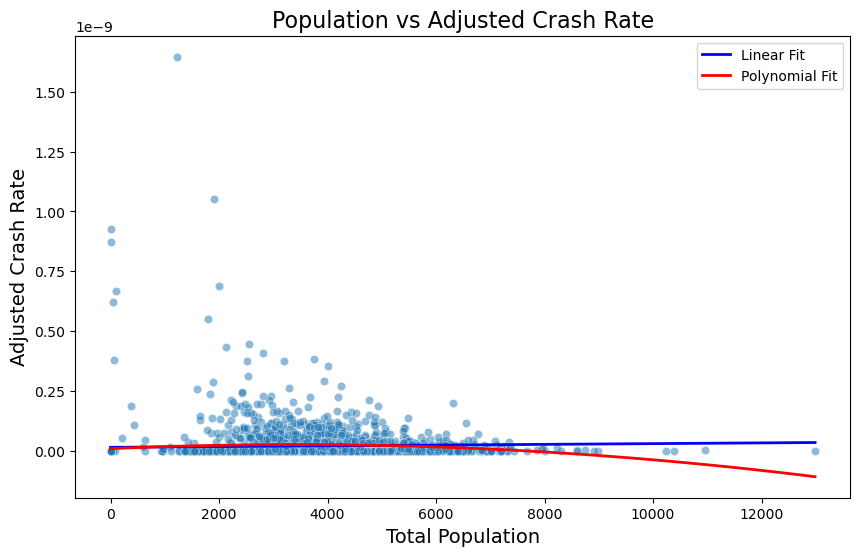

/tmp/ipykernel_173/3283173339.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='density_group', y='adjusted_crash_rate', data=grouped_data, palette='viridis')


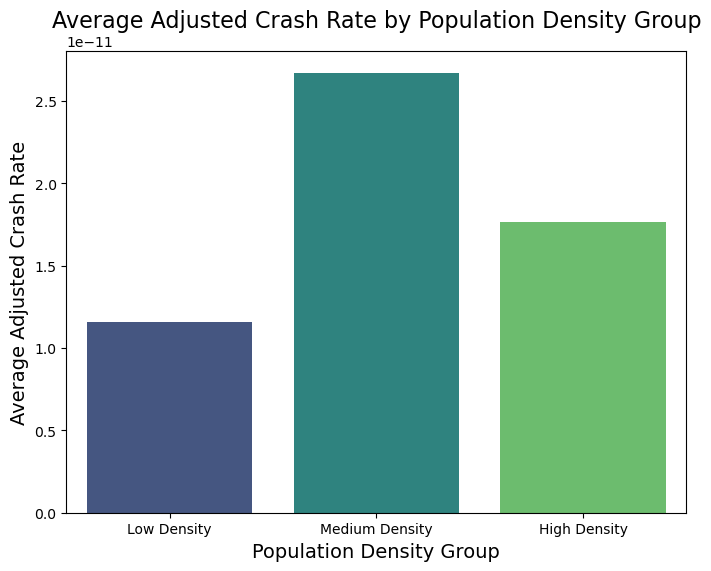

Interactive map saved as Adjusted_Low_Density_High_Crash_Map.html


In [10]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import seaborn as sns
import folium

# 1. Load data
tracts_path = "2020_Census_Tracts.shp"
census_tracts = gpd.read_file(tracts_path)

bike_crashes_path = "23_Bicycle_Crashes.csv"
bike_crashes = pd.read_csv(bike_crashes_path)

population_data_path = "Cleaned_Census_Population.csv"
population_data = pd.read_csv(population_data_path)

# 2. Data processing
bike_crashes_gdf = gpd.GeoDataFrame(
    bike_crashes,
    geometry=gpd.points_from_xy(bike_crashes.POINT_X, bike_crashes.POINT_Y),
    crs="EPSG:4326"
)
census_tracts = census_tracts.to_crs("EPSG:4326")

# Spatial join
bike_crashes_gdf = gpd.sjoin(bike_crashes_gdf, census_tracts, how="inner", predicate="within")
crash_counts = bike_crashes_gdf.groupby('LABEL').size().reset_index(name='crash_count')

population_data['LABEL'] = population_data['Census_Tract_Name'].astype(str)
merged_data = census_tracts.merge(population_data, on="LABEL", how="left")
merged_data = merged_data.merge(crash_counts, on="LABEL", how="left")
merged_data['crash_count'] = merged_data['crash_count'].fillna(0)
merged_data['Total population'] = merged_data['Total population'].fillna(0)

# Compute crash rate (adjusted logic: crashes per person per km²)
merged_data['adjusted_crash_rate'] = merged_data['crash_count'] / (
    merged_data['Total population'] * merged_data['ShapeSTAre']
)
merged_data['adjusted_crash_rate'] = merged_data['adjusted_crash_rate'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 3. Linear regression
X = merged_data[['Total population']].values
y = merged_data['adjusted_crash_rate'].values

linear_model = LinearRegression()
linear_model.fit(X, y)

# Output linear regression results
print(f"Linear Regression - Coefficient: {linear_model.coef_[0]}")
print(f"Linear Regression - Intercept: {linear_model.intercept_}")
print(f"Linear Regression - R²: {linear_model.score(X, y)}")

# 4. Group analysis
merged_data['density_group'] = pd.qcut(merged_data['Total population'], q=3, labels=['Low Density', 'Medium Density', 'High Density'])

# Compute average crash rate per group
grouped_data = merged_data.groupby('density_group')['adjusted_crash_rate'].mean().reset_index()
print("Group Analysis Results:")
print(grouped_data)

# Extract low-density regions with high crash rate
low_density_high_crash = merged_data[(merged_data['density_group'] == 'Low Density') & (merged_data['adjusted_crash_rate'] > 0.0005)]
print("Low-Density Regions with High Crash Rate:")
print(low_density_high_crash[['LABEL', 'adjusted_crash_rate', 'geometry']])

# 5. Polynomial regression
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

poly_model = LinearRegression()
poly_model.fit(X_poly, y)

# Output polynomial regression results
print(f"Polynomial Regression - Intercept: {poly_model.intercept_}")
print(f"Polynomial Regression - Coefficients: {poly_model.coef_}")
print(f"Polynomial Regression - R²: {poly_model.score(X_poly, y)}")

# 6. Visualization
# Scatter plot with regression lines
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total population', y='adjusted_crash_rate', data=merged_data, alpha=0.5)
plt.title('Population vs Adjusted Crash Rate', fontsize=16)
plt.xlabel('Total Population', fontsize=14)
plt.ylabel('Adjusted Crash Rate', fontsize=14)

# Linear regression line
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
linear_fit = linear_model.predict(x_range)
plt.plot(x_range, linear_fit, color='blue', label='Linear Fit', linewidth=2)

# Polynomial regression line
poly_fit = poly_model.predict(poly.fit_transform(x_range))
plt.plot(x_range, poly_fit, color='red', label='Polynomial Fit', linewidth=2)

plt.legend()
plt.show()

# Group analysis bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='density_group', y='adjusted_crash_rate', data=grouped_data, palette='viridis')
plt.title('Average Adjusted Crash Rate by Population Density Group', fontsize=16)
plt.xlabel('Population Density Group', fontsize=14)
plt.ylabel('Average Adjusted Crash Rate', fontsize=14)
plt.show()

# 7. Interactive map creation
m = folium.Map(location=[34.05, -118.25], zoom_start=10)  # Centered at Los Angeles

# Add adjusted crash rate as a choropleth layer
folium.Choropleth(
    geo_data=merged_data,
    name='Adjusted Crash Rate',
    data=merged_data,
    columns=['LABEL', 'adjusted_crash_rate'],
    key_on='feature.properties.LABEL',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Adjusted Crash Rate'
).add_to(m)

# Mark low-density high-crash regions
for _, row in low_density_high_crash.iterrows():
    centroid = row['geometry'].centroid
    lat, lon = centroid.y, centroid.x

    popup_info = f"""
    <b>Tract Label:</b> {row['LABEL']}<br>
    <b>Adjusted Crash Rate:</b> {row['adjusted_crash_rate']:.5f}<br>
    <b>Total Population:</b> {row['Total population']}<br>
    """
    folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(popup_info, max_width=300),
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# Save map
m.save("Adjusted_Low_Density_High_Crash_Map.html")
print("Interactive map saved as Adjusted_Low_Density_High_Crash_Map.html")


/tmp/ipykernel_173/2383505894.py:52: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/tmp/ipykernel_173/2383505894.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1200x800 with 0 Axes>

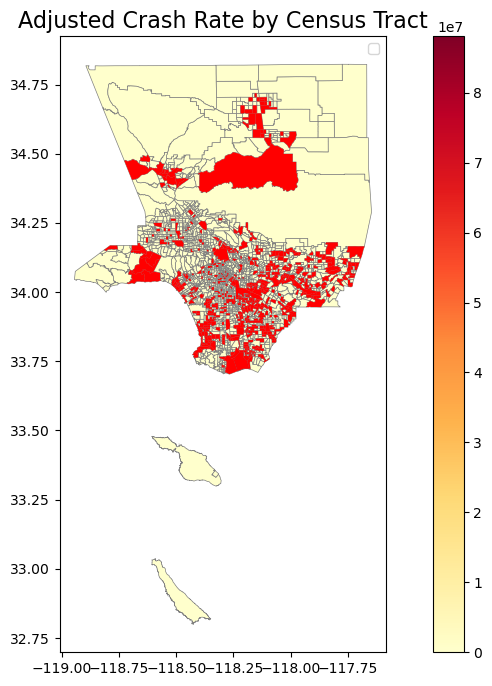

Interactive map saved as High_Crash_Rate_Map.html


In [11]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import seaborn as sns
import folium

# 1. Load data
tracts_path = "2020_Census_Tracts.shp"
census_tracts = gpd.read_file(tracts_path)

bike_crashes_path = "23_Bicycle_Crashes.csv"
bike_crashes = pd.read_csv(bike_crashes_path)

population_data_path = "Cleaned_Census_Population.csv"
population_data = pd.read_csv(population_data_path)

# 2. Data processing
bike_crashes_gdf = gpd.GeoDataFrame(
    bike_crashes,
    geometry=gpd.points_from_xy(bike_crashes.POINT_X, bike_crashes.POINT_Y),
    crs="EPSG:4326"
)
census_tracts = census_tracts.to_crs("EPSG:4326")

# Spatial join
bike_crashes_gdf = gpd.sjoin(bike_crashes_gdf, census_tracts, how="inner", predicate="within")
crash_counts = bike_crashes_gdf.groupby('LABEL').size().reset_index(name='crash_count')

population_data['LABEL'] = population_data['Census_Tract_Name'].astype(str)
merged_data = census_tracts.merge(population_data, on="LABEL", how="left")
merged_data = merged_data.merge(crash_counts, on="LABEL", how="left")
merged_data['crash_count'] = merged_data['crash_count'].fillna(0)
merged_data['Total population'] = merged_data['Total population'].fillna(0)
merged_data['Population density'] = merged_data['Total population'] / merged_data['ShapeSTAre']

# Compute adjusted crash rate
merged_data['adjusted_crash_rate'] = merged_data['crash_count'] / merged_data['Population density']
merged_data['adjusted_crash_rate'] = merged_data['adjusted_crash_rate'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 3. High crash rate analysis
high_crash_threshold = 0.0005  # Set a threshold for high crash rate
high_crash_areas = merged_data[merged_data['adjusted_crash_rate'] > high_crash_threshold]

# 4. Static map visualization
plt.figure(figsize=(12, 8))
base = merged_data.plot(column='adjusted_crash_rate', cmap='YlOrRd', legend=True, figsize=(12, 8), linewidth=0.5, edgecolor='gray')
high_crash_areas.plot(ax=base, color='red', markersize=50, label="High Crash Rate Areas")
plt.title("Adjusted Crash Rate by Census Tract", fontsize=16)
plt.legend()
plt.show()

# 5. Interactive map visualization
m = folium.Map(location=[34.05, -118.25], zoom_start=10)  # Los Angeles center coordinates

# Add choropleth layer for crash rates
folium.Choropleth(
    geo_data=merged_data,
    name='Adjusted Crash Rate',
    data=merged_data,
    columns=['LABEL', 'adjusted_crash_rate'],
    key_on='feature.properties.LABEL',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Adjusted Crash Rate'
).add_to(m)

# Add markers for high crash rate areas
for _, row in high_crash_areas.iterrows():
    centroid = row['geometry'].centroid
    popup_info = f"""
    <b>Tract Label:</b> {row['LABEL']}<br>
    <b>Adjusted Crash Rate:</b> {row['adjusted_crash_rate']:.5f}<br>
    <b>Total Population:</b> {row['Total population']}<br>
    """
    folium.Marker(
        location=[centroid.y, centroid.x],
        popup=folium.Popup(popup_info, max_width=300),
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# Save the interactive map
m.save("High_Crash_Rate_Map.html")
print("Interactive map saved as High_Crash_Rate_Map.html")


Linear Regression - Coefficient: -0.00011780876957592112
Linear Regression - Intercept: 0.10224393857413872
Linear Regression - R²: 0.000620660088387015
Group Analysis Results:
    density_group  adjusted_crash_rate
0     Low Density             0.178598
1  Medium Density             0.003243
2    High Density             0.001068
Low-Density Regions with High Crash Rate:
        LABEL  adjusted_crash_rate  \
170   1211.02             0.036004   
582   2060.51             0.052323   
773   2260.02             0.103319   
1099  3009.01             0.013666   
1164  4002.05             0.103759   
1172  4004.04             0.129217   
1185  4013.03             0.027862   
1186  4013.04             0.021536   
1246  4034.09             0.012939   
1357  4087.03             0.033209   
1380  4307.21             0.079997   
1446  4604.01             0.052868   
1559  5002.02             0.013912   
1670  5323.03             0.059448   
1671  5323.04             0.087893   
1768  5410.03    

/tmp/ipykernel_173/2123512817.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = merged_data.groupby('density_group')['adjusted_crash_rate'].mean().reset_index()


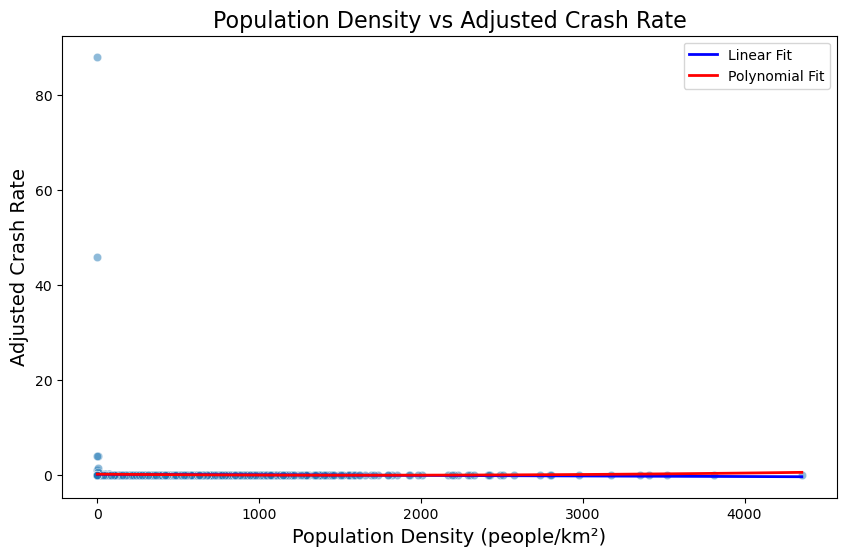

/tmp/ipykernel_173/2123512817.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='density_group', y='adjusted_crash_rate', data=grouped_data, palette='viridis')


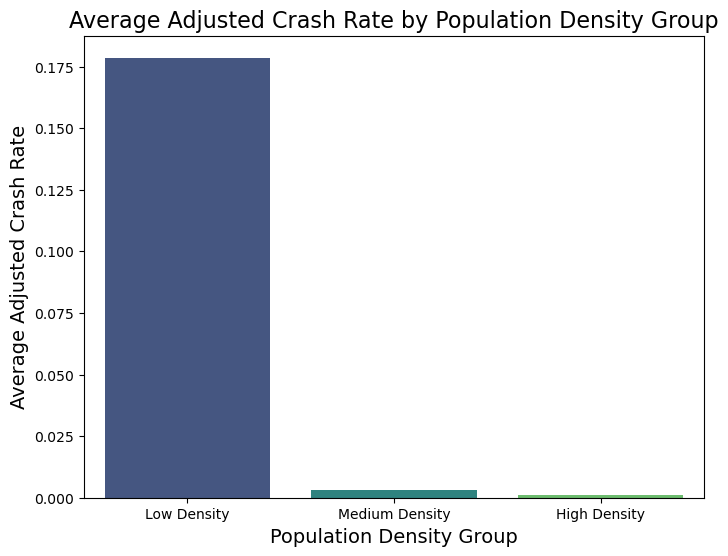

Interactive map saved as Population_Density_Adjusted_Crash_Map.html


In [12]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import seaborn as sns
import folium

# 1. Load data
tracts_path = "2020_Census_Tracts.shp"
census_tracts = gpd.read_file(tracts_path)

bike_crashes_path = "23_Bicycle_Crashes.csv"
bike_crashes = pd.read_csv(bike_crashes_path)

population_data_path = "Cleaned_Census_Population.csv"
population_data = pd.read_csv(population_data_path)

# 2. Data processing
bike_crashes_gdf = gpd.GeoDataFrame(
    bike_crashes,
    geometry=gpd.points_from_xy(bike_crashes.POINT_X, bike_crashes.POINT_Y),
    crs="EPSG:4326"
)
census_tracts = census_tracts.to_crs("EPSG:4326")

# Spatial join
bike_crashes_gdf = gpd.sjoin(bike_crashes_gdf, census_tracts, how="inner", predicate="within")
crash_counts = bike_crashes_gdf.groupby('LABEL').size().reset_index(name='crash_count')

population_data['LABEL'] = population_data['Census_Tract_Name'].astype(str)
merged_data = census_tracts.merge(population_data, on="LABEL", how="left")
merged_data = merged_data.merge(crash_counts, on="LABEL", how="left")
merged_data['crash_count'] = merged_data['crash_count'].fillna(0)
merged_data['Total population'] = merged_data['Total population'].fillna(0)
merged_data['ShapeSTAre'] = merged_data['ShapeSTAre'].fillna(0)

# Compute population density (people/km²)
merged_data['population_density'] = merged_data['Total population'] / (merged_data['ShapeSTAre'] / 1e6)

# Compute adjusted crash rate based on population density
merged_data['adjusted_crash_rate'] = merged_data['crash_count'] / merged_data['population_density']
merged_data['adjusted_crash_rate'] = merged_data['adjusted_crash_rate'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 3. Linear regression
X = merged_data[['population_density']].values
y = merged_data['adjusted_crash_rate'].values

linear_model = LinearRegression()
linear_model.fit(X, y)

# Output linear regression results
print(f"Linear Regression - Coefficient: {linear_model.coef_[0]}")
print(f"Linear Regression - Intercept: {linear_model.intercept_}")
print(f"Linear Regression - R²: {linear_model.score(X, y)}")

# 4. Group analysis
merged_data['density_group'] = pd.qcut(merged_data['population_density'], q=3, labels=['Low Density', 'Medium Density', 'High Density'])

# Compute average crash rate per group
grouped_data = merged_data.groupby('density_group')['adjusted_crash_rate'].mean().reset_index()
print("Group Analysis Results:")
print(grouped_data)

# Extract low-density regions with high crash rate
low_density_high_crash = merged_data[(merged_data['density_group'] == 'Low Density') & (merged_data['adjusted_crash_rate'] > 0.0005)]
print("Low-Density Regions with High Crash Rate:")
print(low_density_high_crash[['LABEL', 'adjusted_crash_rate', 'geometry']])

# 5. Polynomial regression
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

poly_model = LinearRegression()
poly_model.fit(X_poly, y)

# Output polynomial regression results
print(f"Polynomial Regression - Intercept: {poly_model.intercept_}")
print(f"Polynomial Regression - Coefficients: {poly_model.coef_}")
print(f"Polynomial Regression - R²: {poly_model.score(X_poly, y)}")

# 6. Visualization
# Scatter plot with regression lines
plt.figure(figsize=(10, 6))
sns.scatterplot(x='population_density', y='adjusted_crash_rate', data=merged_data, alpha=0.5)
plt.title('Population Density vs Adjusted Crash Rate', fontsize=16)
plt.xlabel('Population Density (people/km²)', fontsize=14)
plt.ylabel('Adjusted Crash Rate', fontsize=14)

# Linear regression line
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
linear_fit = linear_model.predict(x_range)
plt.plot(x_range, linear_fit, color='blue', label='Linear Fit', linewidth=2)

# Polynomial regression line
poly_fit = poly_model.predict(poly.fit_transform(x_range))
plt.plot(x_range, poly_fit, color='red', label='Polynomial Fit', linewidth=2)

plt.legend()
plt.show()

# Group analysis bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='density_group', y='adjusted_crash_rate', data=grouped_data, palette='viridis')
plt.title('Average Adjusted Crash Rate by Population Density Group', fontsize=16)
plt.xlabel('Population Density Group', fontsize=14)
plt.ylabel('Average Adjusted Crash Rate', fontsize=14)
plt.show()

# 7. Interactive map creation
m = folium.Map(location=[34.05, -118.25], zoom_start=10)  # Centered at Los Angeles

# Add adjusted crash rate as a choropleth layer
folium.Choropleth(
    geo_data=merged_data,
    name='Adjusted Crash Rate',
    data=merged_data,
    columns=['LABEL', 'adjusted_crash_rate'],
    key_on='feature.properties.LABEL',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Adjusted Crash Rate'
).add_to(m)

# Mark low-density high-crash regions
for _, row in low_density_high_crash.iterrows():
    centroid = row['geometry'].centroid
    lat, lon = centroid.y, centroid.x

    popup_info = f"""
    <b>Tract Label:</b> {row['LABEL']}<br>
    <b>Adjusted Crash Rate:</b> {row['adjusted_crash_rate']:.5f}<br>
    <b>Population Density:</b> {row['population_density']:.2f}<br>
    """
    folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(popup_info, max_width=300),
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# Save map
m.save("Population_Density_Adjusted_Crash_Map.html")
print("Interactive map saved as Population_Density_Adjusted_Crash_Map.html")
